<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/classification/Network_classification_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [2]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [0]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.85, svd_solver='full')

In [0]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.85, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [0]:
train_data_stand_pca.shape

(131, 7)

##Z score dei dati dopo PCA

In [0]:
mean = train_data_stand_pca.mean(axis=0)
std = train_data_stand_pca.std(axis=0)
train_data_stand_pca = train_data_stand_pca - mean
train_data_stand_pca /= std

In [0]:
test_data_stand_pca = test_data_stand_pca - mean
test_data_stand_pca /= std

#Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(7,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.005, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

3

In [0]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  1   2   4   5   8  10  11  12  13  14  17  20  21  22  23  24  25  26
  27  29  30  31  33  34  37  38  39  40  41  42  43  46  47  48  49  50
  55  58  60  61  62  63  64  65  67  69  70  71  73  75  76  77  79  81
  82  83  84  85  87  88  89  91  92  94  96  97  98  99 100 101 103 106
 107 108 110 115 116 117 118 119 121 122 124 126 127 129 130] TEST: [  0   3   6   7   9  15  16  18  19  28  32  35  36  44  45  51  52  53
  54  56  57  59  66  68  72  74  78  80  86  90  93  95 102 104 105 109
 111 112 113 114 120 123 125 128]
TRAIN: [  0   1   3   6   7   8   9  10  13  14  15  16  17  18  19  20  23  24
  25  28  30  31  32  33  35  36  37  39  40  44  45  47  49  51  52  53
  54  55  56  57  58  59  63  64  66  67  68  71  72  73  74  78  80  81
  82  84  85  86  88  89  90  92  93  94  95  98  99 101 102 104 105 106
 109 110 111 112 113 114 115 117 118 120 122 123 125 128 129] TEST: [  2   4   5  11  12  21  22  26  27  29  34  38  41  42  43  46  48  50
  60  61  62 

In [0]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [0]:
num_epochs = 300
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 87 samples, validate on 44 samples
Epoch 1/300
87/87 [==============================] - 1s 7ms/step - loss: 1.1639 - acc: 0.5632 - val_loss: 1.3481 - val_acc: 0.4091
Epoch 2/300
87/87 [==============================] - 0s 285us/step - loss: 1.1417 - acc: 0.5632 - val_loss: 1.3274 - val_acc: 0.4091
Epoch 3/300
87/87 [==============================] - 0s 332us/step - loss: 1.1208 - acc: 0.5747 - val_loss: 1.3075 - val_acc: 0.3864
Epoch 4/300
87/87 [==============================] - 0s 248us/step - loss: 1.1019 - acc: 0.5747 - val_loss: 1.2902 - val_acc: 0.4318
Epoch 5/300
87/87 [==============================] - 0s 253us/step - loss: 1.0871 - acc: 0.5632 - val_loss: 1.2741 - val_acc: 0.4773
Epoch 6/300
87/87 [==============================] - 0s 236us/step - loss: 1.0705 - acc: 0.5517 - val_loss: 1.2613 - val_acc: 0.4545
Epoch 7/300
87/87 [==============================] - 0s 257us/step - loss: 1.0570 - acc: 0.5402 - val_loss: 1.2495 - val_acc: 0.4318
Epoch 8/300
87/87 [========

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
len(all_acc_histories[2])

200

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [0]:
len(average_val_acc_history)

200

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

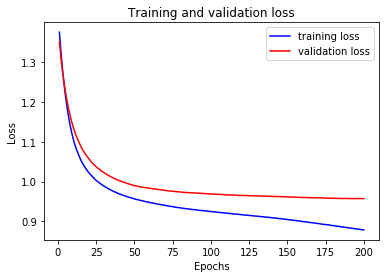

In [0]:
plt.plot(epochs, average_loss_history, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

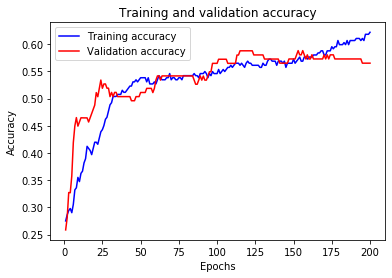

In [0]:
plt.plot(epochs, average_acc_history, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

#Performances on test set

In [0]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/1000
131/131 [==============================] - 0s 3ms/step - loss: 1.2654 - acc: 0.3130
Epoch 2/1000
131/131 [==============================] - 0s 172us/step - loss: 1.2582 - acc: 0.3206
Epoch 3/1000
131/131 [==============================] - 0s 198us/step - loss: 1.2512 - acc: 0.3282
Epoch 4/1000
131/131 [==============================] - 0s 165us/step - loss: 1.2441 - acc: 0.3511
Epoch 5/1000
131/131 [==============================] - 0s 167us/step - loss: 1.2377 - acc: 0.3588
Epoch 6/1000
131/131 [==============================] - 0s 172us/step - loss: 1.2312 - acc: 0.3817
Epoch 7/1000
131/131 [==============================] - 0s 158us/step - loss: 1.2248 - acc: 0.3817
Epoch 8/1000
131/131 [==============================] - 0s 167us/step - loss: 1.2190 - acc: 0.3893
Epoch 9/1000
131/131 [==============================] - 0s 156us/step - loss: 1.2133 - acc: 0.3893
Epoch 10/1000
131/131 [==============================] - 0s 154us/step - loss: 1.2078 - acc: 0.3893
Epoch 11/10

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
test_acc


0.20588235294117646

#Prova con LDA

##LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [0]:
train_data_stand_lda = lda.fit(train_data_stand, train_labels_dec).transform(train_data_stand)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [0]:
train_data_stand_lda.shape

(131, 2)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

###Z score dei dati dopo PCA

In [0]:
mean = train_data_stand_lda.mean(axis=0)
std = train_data_stand_lda.std(axis=0)
train_data_stand_lda = train_data_stand_lda - mean
train_data_stand_lda /= std

In [0]:
test_data_stand_lda = test_data_stand_lda - mean
test_data_stand_lda /= std

##Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_lda, train_labels_dec)

3

In [0]:
for train_index, test_index in skf.split(train_data_stand_lda, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  1   2   4   5   8  10  11  12  13  14  17  20  21  22  23  24  25  26
  27  29  30  31  33  34  37  38  39  40  41  42  43  46  47  48  49  50
  55  58  60  61  62  63  64  65  67  69  70  71  73  75  76  77  79  81
  82  83  84  85  87  88  89  91  92  94  96  97  98  99 100 101 103 106
 107 108 110 115 116 117 118 119 121 122 124 126 127 129 130] TEST: [  0   3   6   7   9  15  16  18  19  28  32  35  36  44  45  51  52  53
  54  56  57  59  66  68  72  74  78  80  86  90  93  95 102 104 105 109
 111 112 113 114 120 123 125 128]
TRAIN: [  0   1   3   6   7   8   9  10  13  14  15  16  17  18  19  20  23  24
  25  28  30  31  32  33  35  36  37  39  40  44  45  47  49  51  52  53
  54  55  56  57  58  59  63  64  66  67  68  71  72  73  74  78  80  81
  82  84  85  86  88  89  90  92  93  94  95  98  99 101 102 104 105 106
 109 110 111 112 113 114 115 117 118 120 122 123 125 128 129] TEST: [  2   4   5  11  12  21  22  26  27  29  34  38  41  42  43  46  48  50
  60  61  62 

In [0]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [0]:
num_epochs = 200
all_acc_histories_lda = []
all_loss_histories_lda = []
all_val_acc_histories_lda = []
all_val_loss_histories_lda = []

for train_index, val_index in skf.split(train_data_stand_lda, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_lda[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_lda[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories_lda.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories_lda.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories_lda.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories_lda.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 87 samples, validate on 44 samples
Epoch 1/200
87/87 [==============================] - 0s 3ms/step - loss: 1.0956 - acc: 0.2069 - val_loss: 1.0482 - val_acc: 0.3182
Epoch 2/200
87/87 [==============================] - 0s 196us/step - loss: 1.0795 - acc: 0.3333 - val_loss: 1.0327 - val_acc: 0.3636
Epoch 3/200
87/87 [==============================] - 0s 200us/step - loss: 1.0640 - acc: 0.3793 - val_loss: 1.0181 - val_acc: 0.4091
Epoch 4/200
87/87 [==============================] - 0s 199us/step - loss: 1.0490 - acc: 0.4483 - val_loss: 1.0036 - val_acc: 0.4773
Epoch 5/200
87/87 [==============================] - 0s 208us/step - loss: 1.0348 - acc: 0.4828 - val_loss: 0.9903 - val_acc: 0.5455
Epoch 6/200
87/87 [==============================] - 0s 203us/step - loss: 1.0214 - acc: 0.5172 - val_loss: 0.9776 - val_acc: 0.5455
Epoch 7/200
87/87 [==============================] - 0s 201us/step - loss: 1.0085 - acc: 0.5287 - val_loss: 0.9656 - val_acc: 0.5682
Epoch 8/200
87/87 [========

In [0]:
val_data

array([[-1.05997689,  1.78480965],
       [-1.70377632,  2.62178086],
       [-0.88024938,  1.10677205],
       [-1.6221035 ,  2.53797672],
       [-1.20438162,  1.42505216],
       [-0.72831295, -0.54994201],
       [-0.71544696, -1.05313817],
       [-0.78016566, -0.87184816],
       [-0.66616332, -1.04551976],
       [-0.80814457, -1.1534213 ],
       [-0.18117691, -0.5752502 ],
       [-0.5797643 , -0.90332856],
       [-0.75946851, -0.80650801],
       [-0.47381325, -0.94095818],
       [-0.51651934, -0.3343159 ],
       [-0.9078223 , -0.51343018],
       [-0.83040609, -0.52280685],
       [-0.8364583 , -1.1044959 ],
       [-1.06491561, -0.23177315],
       [-1.09349754, -1.34108765],
       [-1.44273181, -1.36811384],
       [-0.39121396, -1.41060042],
       [-0.96660223, -1.52141472],
       [-0.29851281, -1.2365264 ],
       [-0.66466281, -0.89831149],
       [ 1.12079905,  0.10919806],
       [ 0.41839628,  0.46087105],
       [ 0.81585568,  0.3499919 ],
       [ 0.6952246 ,

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
len(all_acc_histories[2])

200

In [0]:
average_acc_history_lda = [np.mean([x[i] for x in all_acc_histories_lda]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history_lda = [np.mean([x[i] for x in all_loss_histories_lda]) for i in range(num_epochs)]
average_val_acc_history_lda = [np.mean([x[i] for x in all_val_acc_histories_lda]) for i in range(num_epochs)]
average_val_loss_history_lda = [np.mean([x[i] for x in all_val_loss_histories_lda]) for i in range(num_epochs)]


In [0]:
len(average_val_acc_history)

200

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

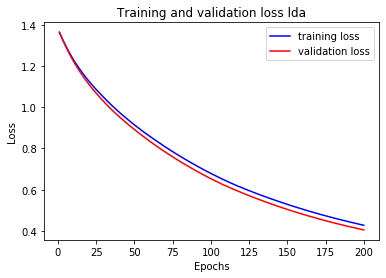

In [0]:
plt.plot(epochs, average_loss_history_lda, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_lda, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

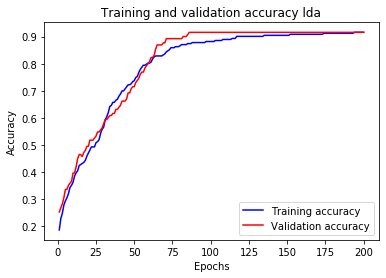

In [0]:
plt.plot(epochs, average_acc_history_lda, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_lda, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [0]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/200
131/131 [==============================] - 0s 3ms/step - loss: 1.1954 - acc: 0.5420
Epoch 2/200
131/131 [==============================] - 0s 178us/step - loss: 1.1574 - acc: 0.5725
Epoch 3/200
131/131 [==============================] - 0s 157us/step - loss: 1.1221 - acc: 0.5649
Epoch 4/200
131/131 [==============================] - 0s 159us/step - loss: 1.0884 - acc: 0.5649
Epoch 5/200
131/131 [==============================] - 0s 175us/step - loss: 1.0563 - acc: 0.5649
Epoch 6/200
131/131 [==============================] - 0s 153us/step - loss: 1.0275 - acc: 0.5649
Epoch 7/200
131/131 [==============================] - 0s 157us/step - loss: 1.0002 - acc: 0.5649
Epoch 8/200
131/131 [==============================] - 0s 149us/step - loss: 0.9746 - acc: 0.5573
Epoch 9/200
131/131 [==============================] - 0s 190us/step - loss: 0.9505 - acc: 0.5573
Epoch 10/200
131/131 [==============================] - 0s 162us/step - loss: 0.9285 - acc: 0.5649
Epoch 11/200
131/131 

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
test_acc


0.11764705882352941

Si comporta molto bene in training e in validation ma si comporta male in test

Remove correlated features manually

# Prova remove correlated features with treshold

https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-i-selecting-for-feature-information?ex=14

In [0]:
#create a positive correlation matrix
corr_df = train_data_stand.corr().abs()

In [0]:
#create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

In [0]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [0]:
tri_df = corr_df.mask(mask)

In [0]:
tri_df

,VoxelVolume,Maximum3DDiameter,MeshVolume,MajorAxisLength,Sphericity,LeastAxisLength,Elongation,SurfaceVolumeRatio,Maximum2DDiameterSlice,Flatness,SurfaceArea,MinorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,GrayLevelVariance,HighGrayLevelEmphasis,DependenceEntropy,DependenceNonUniformity,GrayLevelNonUniformity,SmallDependenceEmphasis,SmallDependenceHighGrayLevelEmphasis,DependenceNonUniformityNormalized,LargeDependenceEmphasis,LargeDependenceLowGrayLevelEmphasis,DependenceVariance,LargeDependenceHighGrayLevelEmphasis,SmallDependenceLowGrayLevelEmphasis,LowGrayLevelEmphasis,JointAverage,SumAverage,JointEntropy,ClusterShade,MaximumProbability,Idmn,JointEnergy,Contrast,DifferenceEntropy,InverseVariance,DifferenceVariance,Idn,...,10Percentile,Kurtosis,Mean,ShortRunLowGrayLevelEmphasis,GrayLevelVariance.1,LowGrayLevelRunEmphasis,GrayLevelNonUniformityNormalized,RunVariance,GrayLevelNonUniformity.1,LongRunEmphasis,ShortRunHighGrayLevelEmphasis,RunLengthNonUniformity,ShortRunEmphasis,LongRunHighGrayLevelEmphasis,RunPercentage,LongRunLowGrayLevelEmphasis,RunEntropy,HighGrayLevelRunEmphasis,RunLengthNonUniformityNormalized,GrayLevelVariance.2,ZoneVariance,GrayLevelNonUniformityNormalized.1,SizeZoneNonUniformityNormalized,SizeZoneNonUniformity,GrayLevelNonUniformity.2,LargeAreaEmphasis,SmallAreaHighGrayLevelEmphasis,ZonePercentage,LargeAreaLowGrayLevelEmphasis,LargeAreaHighGrayLevelEmphasis,HighGrayLevelZoneEmphasis,SmallAreaEmphasis,LowGrayLevelZoneEmphasis,ZoneEntropy,SmallAreaLowGrayLevelEmphasis,Coarseness,Complexity,Strength,Contrast.1,Busyness
VoxelVolume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum3DDiameter,0.821982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MeshVolume,0.999999,0.821800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MajorAxisLength,0.785606,0.964760,0.785457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sphericity,0.329751,0.678628,0.329524,0.694906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Coarseness,0.401634,0.586992,0.401370,0.546184,0.356708,0.569919,0.048602,0.813595,0.614989,0.094676,0.471734,0.598815,0.567029,0.554227,0.192052,0.605729,0.246122,0.406714,0.351606,0.669357,0.183179,0.731964,0.417524,0.077465,0.379163,0.437111,0.787425,0.182358,0.624801,0.624801,0.317491,0.119708,0.324753,0.661086,0.326758,0.468498,0.481677,0.578282,0.

In [0]:
#Find columns that meet threshold
to_drop = [c for c in tri_df.columns if any(tri_df[c]>0.70)]
to_drop

['VoxelVolume',
 'Maximum3DDiameter',
 'MeshVolume',
 'MajorAxisLength',
 'LeastAxisLength',
 'Elongation',
 'SurfaceVolumeRatio',
 'Maximum2DDiameterSlice',
 'SurfaceArea',
 'MinorAxisLength',
 'Maximum2DDiameterColumn',
 'Maximum2DDiameterRow',
 'GrayLevelVariance',
 'HighGrayLevelEmphasis',
 'DependenceEntropy',
 'DependenceNonUniformity',
 'GrayLevelNonUniformity',
 'SmallDependenceEmphasis',
 'SmallDependenceHighGrayLevelEmphasis',
 'DependenceNonUniformityNormalized',
 'LargeDependenceEmphasis',
 'LargeDependenceLowGrayLevelEmphasis',
 'DependenceVariance',
 'LargeDependenceHighGrayLevelEmphasis',
 'SmallDependenceLowGrayLevelEmphasis',
 'LowGrayLevelEmphasis',
 'JointAverage',
 'SumAverage',
 'JointEntropy',
 'ClusterShade',
 'MaximumProbability',
 'Idmn',
 'JointEnergy',
 'Contrast',
 'DifferenceEntropy',
 'InverseVariance',
 'DifferenceVariance',
 'Idn',
 'Idm',
 'Correlation',
 'Autocorrelation',
 'SumEntropy',
 'SumSquares',
 'ClusterProminence',
 'Imc2',
 'DifferenceAverage

The reason we used the mask to set half of the matrix to NA value is that we ewnt to avoid removing both features when thay have a strong correlation. 

In [0]:
#Drop those columns
train_data_stand_reduced = train_data_stand.drop(to_drop, axis=1)

In [0]:
#Drop those columns
test_data_stand_reduced = test_data_stand.drop(to_drop, axis=1)

In [0]:
train_data_stand_reduced.shape

(131, 17)

In [0]:
test_data_stand_reduced.shape

(34, 17)

In [0]:
train_data_stand_reduced = train_data_stand_reduced.to_numpy()
test_data_stand_reduced = test_data_stand_reduced.to_numpy()

In [0]:
type(train_data_stand_reduced)

numpy.ndarray

In [0]:
train_data_stand_reduced.shape

(131, 17)

funziona bene, però bisogna stare attenti a basarsi unicamente sul coefficiente di correlazione. Se y = x^2, x e y risulteranno scorrelate secondo il coeffiente di correlazione di Pearson.

##Building Network

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(10, activation='relu', input_shape=(17,)))
  #model.add(layers.Dense(5, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.01, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_reduced, train_labels_dec)

3

In [0]:
for train_index, test_index in skf.split(train_data_stand_reduced, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  1   2   4   5   8  10  11  12  13  14  17  20  21  22  23  24  25  26
  27  29  30  31  33  34  37  38  39  40  41  42  43  46  47  48  49  50
  55  58  60  61  62  63  64  65  67  69  70  71  73  75  76  77  79  81
  82  83  84  85  87  88  89  91  92  94  96  97  98  99 100 101 103 106
 107 108 110 115 116 117 118 119 121 122 124 126 127 129 130] TEST: [  0   3   6   7   9  15  16  18  19  28  32  35  36  44  45  51  52  53
  54  56  57  59  66  68  72  74  78  80  86  90  93  95 102 104 105 109
 111 112 113 114 120 123 125 128]
TRAIN: [  0   1   3   6   7   8   9  10  13  14  15  16  17  18  19  20  23  24
  25  28  30  31  32  33  35  36  37  39  40  44  45  47  49  51  52  53
  54  55  56  57  58  59  63  64  66  67  68  71  72  73  74  78  80  81
  82  84  85  86  88  89  90  92  93  94  95  98  99 101 102 104 105 106
 109 110 111 112 113 114 115 117 118 120 122 123 125 128 129] TEST: [  2   4   5  11  12  21  22  26  27  29  34  38  41  42  43  46  48  50
  60  61  62 

In [0]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [0]:
type(train_data_stand_reduced)

numpy.ndarray

In [0]:
num_epochs = 200
all_acc_histories_reduced = []
all_loss_histories_reduced = []
all_val_acc_histories_reduced = []
all_val_loss_histories_reduced = []

for train_index, val_index in skf.split(train_data_stand_reduced, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_reduced[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_reduced[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history_reduced = history.history['acc']
  all_acc_histories_reduced.append(acc_history)

  loss_history_reduced = history.history['loss']
  all_loss_histories_reduced.append(loss_history)

  acc_val_history_reduced = history.history['val_acc']
  all_val_acc_histories_reduced.append(acc_val_history)

  loss_val_history_reduced = history.history['val_loss']
  all_val_loss_histories_reduced.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 87 samples, validate on 44 samples
Epoch 1/200
87/87 [==============================] - 0s 5ms/step - loss: 1.2852 - acc: 0.3678 - val_loss: 1.2351 - val_acc: 0.4545
Epoch 2/200
87/87 [==============================] - 0s 223us/step - loss: 1.1662 - acc: 0.4023 - val_loss: 1.1834 - val_acc: 0.5227
Epoch 3/200
87/87 [==============================] - 0s 223us/step - loss: 1.0859 - acc: 0.4368 - val_loss: 1.1589 - val_acc: 0.5227
Epoch 4/200
87/87 [==============================] - 0s 239us/step - loss: 1.0316 - acc: 0.4483 - val_loss: 1.1529 - val_acc: 0.5455
Epoch 5/200
87/87 [==============================] - 0s 266us/step - loss: 0.9955 - acc: 0.4828 - val_loss: 1.1452 - val_acc: 0.5455
Epoch 6/200
87/87 [==============================] - 0s 222us/step - loss: 0.9708 - acc: 0.5287 - val_loss: 1.1419 - val_acc: 0.5682
Epoch 7/200
87/87 [==============================] - 0s 251us/step - loss: 0.9524 - acc: 0.5517 - val_loss: 1.1426 - val_acc: 0.5682
Epoch 8/200
87/87 [========

In [0]:
val_data

array([[-2.09052215e-01, -1.30570140e+00, -1.50987053e+00,
         4.78413407e-01, -5.48688420e-01, -2.19260239e-01,
        -3.87514118e-01, -2.35668681e-01, -3.27761894e-01,
        -3.30961271e-01, -8.29963414e-01,  1.09070485e+00,
        -4.68298254e-01, -2.54403631e-01,  2.05362316e-01,
        -1.58492380e-01, -8.76044573e-01],
       [ 1.93706034e+00,  2.47792697e-01, -6.14324644e-01,
        -1.43358516e+00,  1.74280631e-01, -1.01385115e+00,
        -5.98180597e-01,  7.79397065e-02, -3.34625115e-01,
        -3.30973016e-01, -1.31203202e+00,  4.46338623e-02,
        -1.30913346e+00, -5.65265481e-01,  2.19195593e+00,
         9.70100653e-01, -1.05149009e+00],
       [ 7.34257050e-01,  9.68988268e-02,  3.85769839e-01,
         1.61200050e-01, -5.40961150e-01, -3.83658358e-01,
        -1.13750969e-01, -2.28591476e-01, -1.15055286e-01,
        -3.30299955e-01,  1.35982249e-01,  3.71533408e-01,
        -1.21254356e-01, -4.84378805e-01, -5.30458542e-01,
        -4.87994766e-01,  1.8

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
len(all_acc_histories[2])

200

In [0]:
average_acc_history_reduced = [np.mean([x[i] for x in all_acc_histories_reduced]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history_reduced = [np.mean([x[i] for x in all_loss_histories_reduced]) for i in range(num_epochs)]
average_val_acc_history_reduced = [np.mean([x[i] for x in all_val_acc_histories_reduced]) for i in range(num_epochs)]
average_val_loss_history_reduced = [np.mean([x[i] for x in all_val_loss_histories_reduced]) for i in range(num_epochs)]


In [0]:
len(average_val_acc_history_reduced)

200

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 10)                180       
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 33        
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

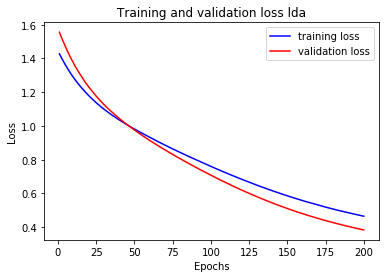

In [0]:
plt.plot(epochs, average_loss_history_reduced, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_reduced, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

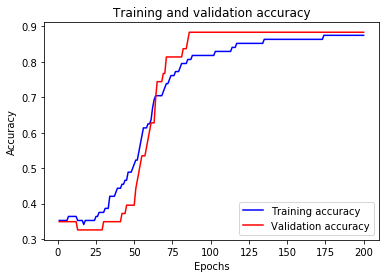

In [0]:
plt.plot(epochs, average_acc_history_reduced, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_reduced, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [0]:
 model = build_model()
 model.fit(train_data_stand_reduced, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_reduced, one_hot_test_labels)
  

Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 1.2255 - acc: 0.3130
Epoch 2/200
131/131 [==============================] - 0s 162us/step - loss: 1.1124 - acc: 0.4122
Epoch 3/200
131/131 [==============================] - 0s 147us/step - loss: 1.0401 - acc: 0.4885
Epoch 4/200
131/131 [==============================] - 0s 144us/step - loss: 0.9896 - acc: 0.5496
Epoch 5/200
131/131 [==============================] - 0s 167us/step - loss: 0.9585 - acc: 0.5802
Epoch 6/200
131/131 [==============================] - 0s 148us/step - loss: 0.9361 - acc: 0.6031
Epoch 7/200
131/131 [==============================] - 0s 175us/step - loss: 0.9200 - acc: 0.6260
Epoch 8/200
131/131 [==============================] - 0s 162us/step - loss: 0.8996 - acc: 0.6183
Epoch 9/200
131/131 [==============================] - 0s 154us/step - loss: 0.8865 - acc: 0.6260
Epoch 10/200
131/131 [==============================] - 0s 158us/step - loss: 0.8760 - acc: 0.6260
Epoch 11/200
131/131 

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
test_acc


0.2647058823529412

Si comporta molto bene in training e in validation ma si comporta male in test